# Install library

In [73]:
from google.colab import data_table
from vega_datasets import data

data_table.enable_dataframe_formatter()

In [74]:
!pip install pystan
!pip install fbprophet
!pip install python-binance
!pip install fireTS
!pip install --upgrade mxnet~=1.7 gluonts


# Load data

In [75]:
from binance.client import Client
import pandas as pd
import matplotlib.dates as mpl_dates
from fbprophet import Prophet

api_key = "zzjxplMhUgyz4Jp1ju8TbAp4mlAAH1HdXnwuNWaHboge5HR6yOOPFKD3x68TR5Iv"
api_secret = "RmBL4M2AJSnzY5Dk4nec0dD0tgD9Eox8vwkqKIyWYkQus7oPhm5a7ilMz2vgMiyP"
client = Client(api_key, api_secret)


In [76]:
# start_date = "1 March, 2019"
# end_date = "30 March, 2021"

# start_date = "30 day ago UTC"
start_date = "600 day ago UTC"


period = Client.KLINE_INTERVAL_1HOUR
# period = Client.KLINE_INTERVAL_5MINUTE
# period = Client.KLINE_INTERVAL_1MINUTE

 
# code = "TRBUSDT"
# code = "1INCHUSDT"
# code = "CHRUSDT"
# code = "DEGOUSDT"
# code = "RLCUSDT"
# code = "WINUSDT"
# code = "GRTUSDT"
code = "BTCUSDT"

# data = client.get_historical_klines(code, period, start_date, end_date)
data = client.get_historical_klines(code, period, start_date)
data = [x[:6] for x in data]

In [77]:
df = pd.DataFrame(data, columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
df.set_index('Date', inplace=True)
df.index = pd.to_datetime(df.index, unit='ms')

In [78]:
df = df[['Open', 'High', 'Low', 'Close','Volume']]
df['Date'] = [mpl_dates.date2num(x) for x in df.index]
df[['Open', 'High', 'Low', 'Close', 'Volume']] = df[['Open', 'High', 'Low', 'Close', 'Volume']].astype(float)
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]

In [79]:
df.head(), df.shape

(                        Open     High      Low    Close       Volume
 Date                                                                
 2020-04-20 04:00:00  7161.55  7220.00  7161.35  7173.57  2597.748867
 2020-04-20 05:00:00  7173.74  7185.02  7154.49  7173.29  1450.438086
 2020-04-20 06:00:00  7173.22  7180.88  7154.01  7167.97  1323.532293
 2020-04-20 07:00:00  7167.95  7198.00  7156.26  7184.94  1536.533089
 2020-04-20 08:00:00  7185.18  7188.32  7136.37  7150.16  1978.186636,
 (14377, 5))

In [80]:
df

Output hidden; open in https://colab.research.google.com to view.

In [81]:
df_term = pd.DataFrame()
df_term['ds'] = df.index
df_term['y'] = df.Close.values


In [82]:
df_term

Output hidden; open in https://colab.research.google.com to view.

# Fit simple model

In [83]:
# m = Prophet(yearly_seasonality=True)
m = Prophet()

m.fit(df_term)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [84]:
fcast_time=1000
future = m.make_future_dataframe(periods= fcast_time, freq='1H')
forecast  = m.predict(future)

In [85]:
forecast.shape

(15377, 19)

In [86]:
forecast[['ds','yhat_lower']].tail(1000)

,ds,yhat_lower
14377,2021-12-11 04:00:00,57053.302113
14378,2021-12-11 05:00:00,56891.447958
14379,2021-12-11 06:00:00,57313.590864
14380,2021-12-11 07:00:00,57249.653571
14381,2021-12-11 08:00:00,57115.467152
...,...,...
15372,2022-01-21 15:00:00,56083.624904
15373,2022-01-21 16:00:00,56531.922060
15374,2022-01-21 17:00:00,56377.959275
15375,2022-01-21 18:00:00,56741.716458


In [87]:
forecast.tail(10)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
15367,2022-01-21 10:00:00,66382.803508,56448.068358,76148.555085,57032.307057,76128.270204,-161.236097,-161.236097,-161.236097,-16.955788,-16.955788,-16.955788,-144.280309,-144.280309,-144.280309,0.0,0.0,0.0,66221.567411
15368,2022-01-21 11:00:00,66388.152660,56411.846073,76970.377500,57019.892907,76150.977849,-150.869264,-150.869264,-150.869264,-12.619917,-12.619917,-12.619917,-138.249347,-138.249347,-138.249347,0.0,0.0,0.0,66237.283396
15369,2022-01-21 12:00:00,66393.501812,56419.647616,76777.730300,57007.478757,76173.685494,-130.276103,-130.276103,-130.276103,0.688993,0.688993,0.688993,-130.965096,-130.965096,-130.965096,0.0,0.0,0.0,66263.225709
15370,2022-01-21 13:00:00,66398.850964,56130.571623,77403.414803,56995.064607,76196.393138,-111.615800,-111.615800,-111.615800,10.884618,10.884618,10.884618,-122.500418,-122.500418,-122.500418,0.0,0.0,0.0,66287.235164
15371,2022-01-21 14:00:00,66404.200116,55823.333235,76705.088024,56970.516854,76219.100783,-102.689237,-102.689237,-102.689237,10.251722,10.251722,10.251722,-112.940959,-112.940959,-112.940959,0.0,0.0,0.0,66301.510879
15372,2022-01-21 15:00:00,66409.549268,56083.624904,76614.401787,56935.894093,76241.808428,-100.776487,-100.776487,-100.776487,1.607626,1.607626,1.607626,-102.384112,-102.384112,-102.384112,0.0,0.0,0.0,66308.772781
15373,2022-01-21 16:00:00,66414.898420,56531.922060,77174.150907,56902.026936,76264.516073,-97.074165,-97.074165,-97.074165,-6.136330,-6.136330,-6.136330,-90.937836,-90.937836,-90.937836,0.0,0.0,0.0,66317.824254
15374,2022-01-21 17:00:00,66420.247572,56377.959275,76780.548507,56871.160935,76287.223717,-86.189280,-86.189280,-86.189280,-7.469928,-7.469928,-7.469928,-78.719352,-78.719352,-78.719352,0.0,0.0,0.0,66334.058292
15375,2022-01-21 18:00:00,66425.596724,56741.716458,76780.246132,56840.294934,76309.931362,-70.657433,-70.657433,-70.657433,-4.803697,-4.803697,-4.803697,-65.853736,-65.853736,-65.853736,0.0,0.0,0.0,66354.939290
15376,2022-01-21 19:00:00,66430.945876,55605.620783,76831.454092,56809.428933,76332.639007,-56.368986,-56.368986,-56.368986,-3.896561,-3.896561,-3.896561,-52.472425,-52.472425,-52.472425,0.0,0.0,0.0,66374.576890


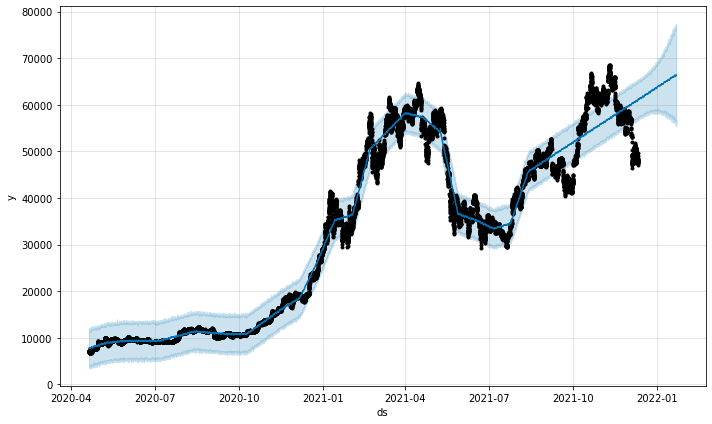

In [88]:
fig = m.plot(forecast)


In [89]:
fig.savefig(code + '-1.png') 

# Change point

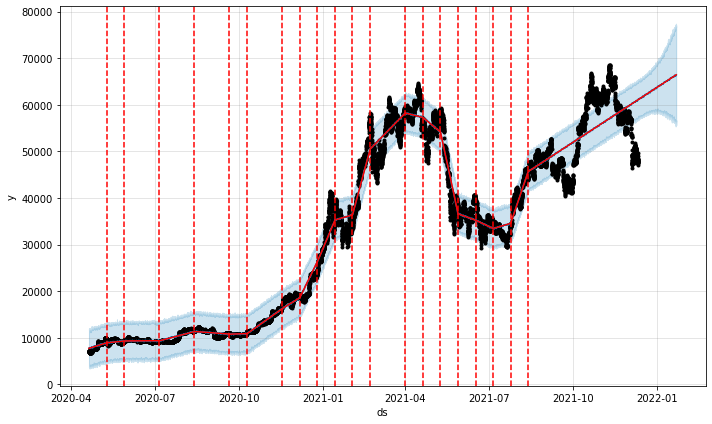

In [90]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)


In [91]:
# Python
# m = Prophet(changepoint_prior_scale=0.5)
# forecast = m.fit(df_term)
# fcast_time=2000
# future = m.make_future_dataframe(periods= fcast_time, freq='1Min')
# forecast  = m.predict(future)
# fig = m.plot(forecast)

# Gluon

In [92]:
from gluonts.dataset.common import ListDataset
training_data = ListDataset(
    [{"start": df.index[0], "target": df.Close.values}],
    freq = "1h"
)

In [93]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer

estimator = DeepAREstimator(freq="1h", prediction_length=120, trainer=Trainer(epochs=10))
predictor = estimator.train(training_data=training_data)



INFO:gluonts.trainer:Start model training
INFO:gluonts.trainer:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:21<00:00,  2.36it/s, epoch=1/10, avg_epoch_loss=9.86]
INFO:gluonts.trainer:Epoch[0] Elapsed time 21.231 seconds
INFO:gluonts.trainer:Epoch[0] Evaluation metric 'epoch_loss'=9.864571
INFO:gluonts.trainer:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:19<00:00,  2.54it/s, epoch=2/10, avg_epoch_loss=8.61]
INFO:gluonts.trainer:Epoch[1] Elapsed time 19.696 seconds
INFO:gluonts.trainer:Epoch[1] Evaluation metric 'epoch_loss'=8.607438
INFO:gluonts.trainer:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:19<00:00,  2.55it/s, epoch=3/10, avg_epoch_loss=8.2] 
INFO:gluonts.trainer:Epoch[2] Elapsed time 19.622 seconds
INFO:gluonts.trainer:Epoch[2] Evaluation metric 'epoch_loss'=8.204367
INFO:gluonts.trainer:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:19<00:00,  2.58it/s, epoch=4/10, avg_epoch_loss=8.03]
INFO:gluonts.trainer:Epoch[3] Elapsed 

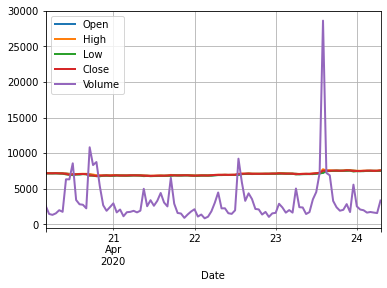

In [94]:
import matplotlib.pyplot as plt
df[:100].plot(linewidth=2)
plt.grid(which='both')
plt.show()

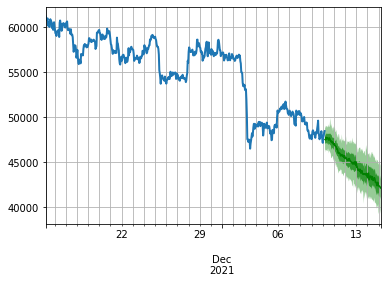

In [98]:
test_data = ListDataset(
    [{"start": df.index[0], "target": df.Close.values}],
    freq = "1h"
)

from gluonts.dataset.util import to_pandas

for test_entry, forecast in zip(test_data, predictor.predict(test_data)):
    to_pandas(test_entry)[-600:].plot(linewidth=2)
    forecast.plot(color='g', prediction_intervals=[50.0, 90.0])
plt.grid(which='both')

In [96]:
df

Output hidden; open in https://colab.research.google.com to view.

In [97]:
---

SyntaxError: ignored

# Logistic model

In [ ]:
# df_term[df_term.cap <= 0]

In [ ]:
# df_term = pd.DataFrame()
# df_term['ds'] = df.index
# df_term['y'] = df.Close.values
# df_term['cap'] = sum(df.Volume.values)

# m = Prophet(growth='logistic')
# m.fit(df_term)

In [ ]:
# fcast_time=40   
# future = m.make_future_dataframe(periods= fcast_time, freq='4H')
# future['cap'] = sum(df.Volume.values)
# forecast  = m.predict(future)

In [ ]:
# m.plot(forecast, xlabel = 'Date', ylabel = code)
# fig = m.plot_components(forecast)

# Add features

In [ ]:
def nfl_sunday(ds):
    date = pd.to_datetime(ds)
    if date.weekday() == 6 and (date.month > 8 or date.month < 2):
        return 1
    else:
        return 0

In [ ]:
df_term = pd.DataFrame()
df_term['ds'] = df.index
df_term['y'] = df.High.values
df_term['nfl_sunday'] = df_term['ds'].apply(nfl_sunday)
# df_term['Volume'] = df.Volume.values
# df_term['Close'] = df.Close.values
# df_term['Low'] = df.Low.values

m = Prophet()
m.add_country_holidays(country_name='US')
# m.add_regressor('Volume')
# m.add_regressor('Low')
# m.add_regressor('Close')
m.add_regressor('nfl_sunday')

m.fit(df_term)

In [ ]:
fcast_time=250   
future = m.make_future_dataframe(periods= fcast_time, freq='1H')
future['nfl_sunday'] = future['ds'].apply(nfl_sunday)
forecast  = m.predict(future)



In [ ]:
forecast

In [ ]:
fig = m.plot(forecast)


In [ ]:
fig.savefig(code + '-2.png') 